# GOLEM Fast Spectrometry Analysis

This notebook demonstrates analysis of GOLEM tokamak diagnostic data using the `golem_data_loader` module.

## Features of the data loader:
- **Type-safe**: Full type annotations for better IDE support
- **Robust error handling**: Automatic retries with configurable delays
- **Flexible**: Load all or specific spectroscopy lines
- **Well-documented**: Comprehensive docstrings and examples
- **Easy to use**: Simple API with sensible defaults

In [91]:
import time
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import butter, lfilter
from scipy import fft

# Import the GOLEM data loader module
from golem_data_loader import GolemDataLoader, SpectroscopyLine

# Increase global font sizes for readability
plt.rcParams.update(
    {
        "font.size": 12,  # base font size
        "axes.labelsize": 18,  # x/y labels
        "axes.titlesize": 18,  # subplot titles
        "xtick.labelsize": 14,  # x tick labels
        "ytick.labelsize": 14,  # y tick labels
        "legend.fontsize": 14,  # legends
        "figure.titlesize": 16,  # suptitle
    }
)


In [92]:
shotno = 50710

## Load Data from GOLEM Web Server

Using the `golem_data_loader` module to fetch diagnostic data with automatic retry logic and error handling.

In [93]:
# Initialize the GOLEM data loader
loader = GolemDataLoader(shotno)

# Load fast spectrometry data
spectrometry_data = loader.load_fast_spectrometry()

# Convert to the original data format for backward compatibility
data = {name: spec_data.raw_dataframe for name, spec_data in spectrometry_data.items()}

# Print loaded data info
for label, spec_data in spectrometry_data.items():
    print(f"{label}: loaded {len(spec_data.time)} rows")

2026-01-10 16:30:20,148 - golem_data_loader.golem_data_loader - INFO - Successfully loaded plasma start time from http://golem.fjfi.cvut.cz/shots/50710/Diagnostics/PlasmaDetection/Results/t_plasma_start
2026-01-10 16:30:20,183 - golem_data_loader.golem_data_loader - INFO - Successfully loaded plasma end time from http://golem.fjfi.cvut.cz/shots/50710/Diagnostics/PlasmaDetection/Results/t_plasma_end
2026-01-10 16:30:20,184 - golem_data_loader.golem_data_loader - INFO - Loaded plasma timing: 1.65 - 13.70 ms
2026-01-10 16:30:20,303 - golem_data_loader.golem_data_loader - INFO - Successfully loaded Hα 656.5nm spectrometry from http://golem.fjfi.cvut.cz/shots/50710/Diagnostics/FastSpectrometry/DAS_raw_data_dir/ch8.csv
2026-01-10 16:30:20,309 - golem_data_loader.golem_data_loader - INFO - Hα 656.5nm: loaded 19999 rows, columns = ['    0', '0.001']
2026-01-10 16:30:20,416 - golem_data_loader.golem_data_loader - INFO - Successfully loaded Cl II 479.5nm spectrometry from http://golem.fjfi.cvut.

Hα 656.5nm: loaded 19999 rows
Cl II 479.5nm: loaded 19999 rows
He I 588nm: loaded 19999 rows
Whole: loaded 19999 rows
C II 514.5nm: loaded 3999 rows
N II 568.6nm: loaded 3999 rows
O I 777nm: loaded 3999 rows
He I 447.1nm: loaded 3999 rows


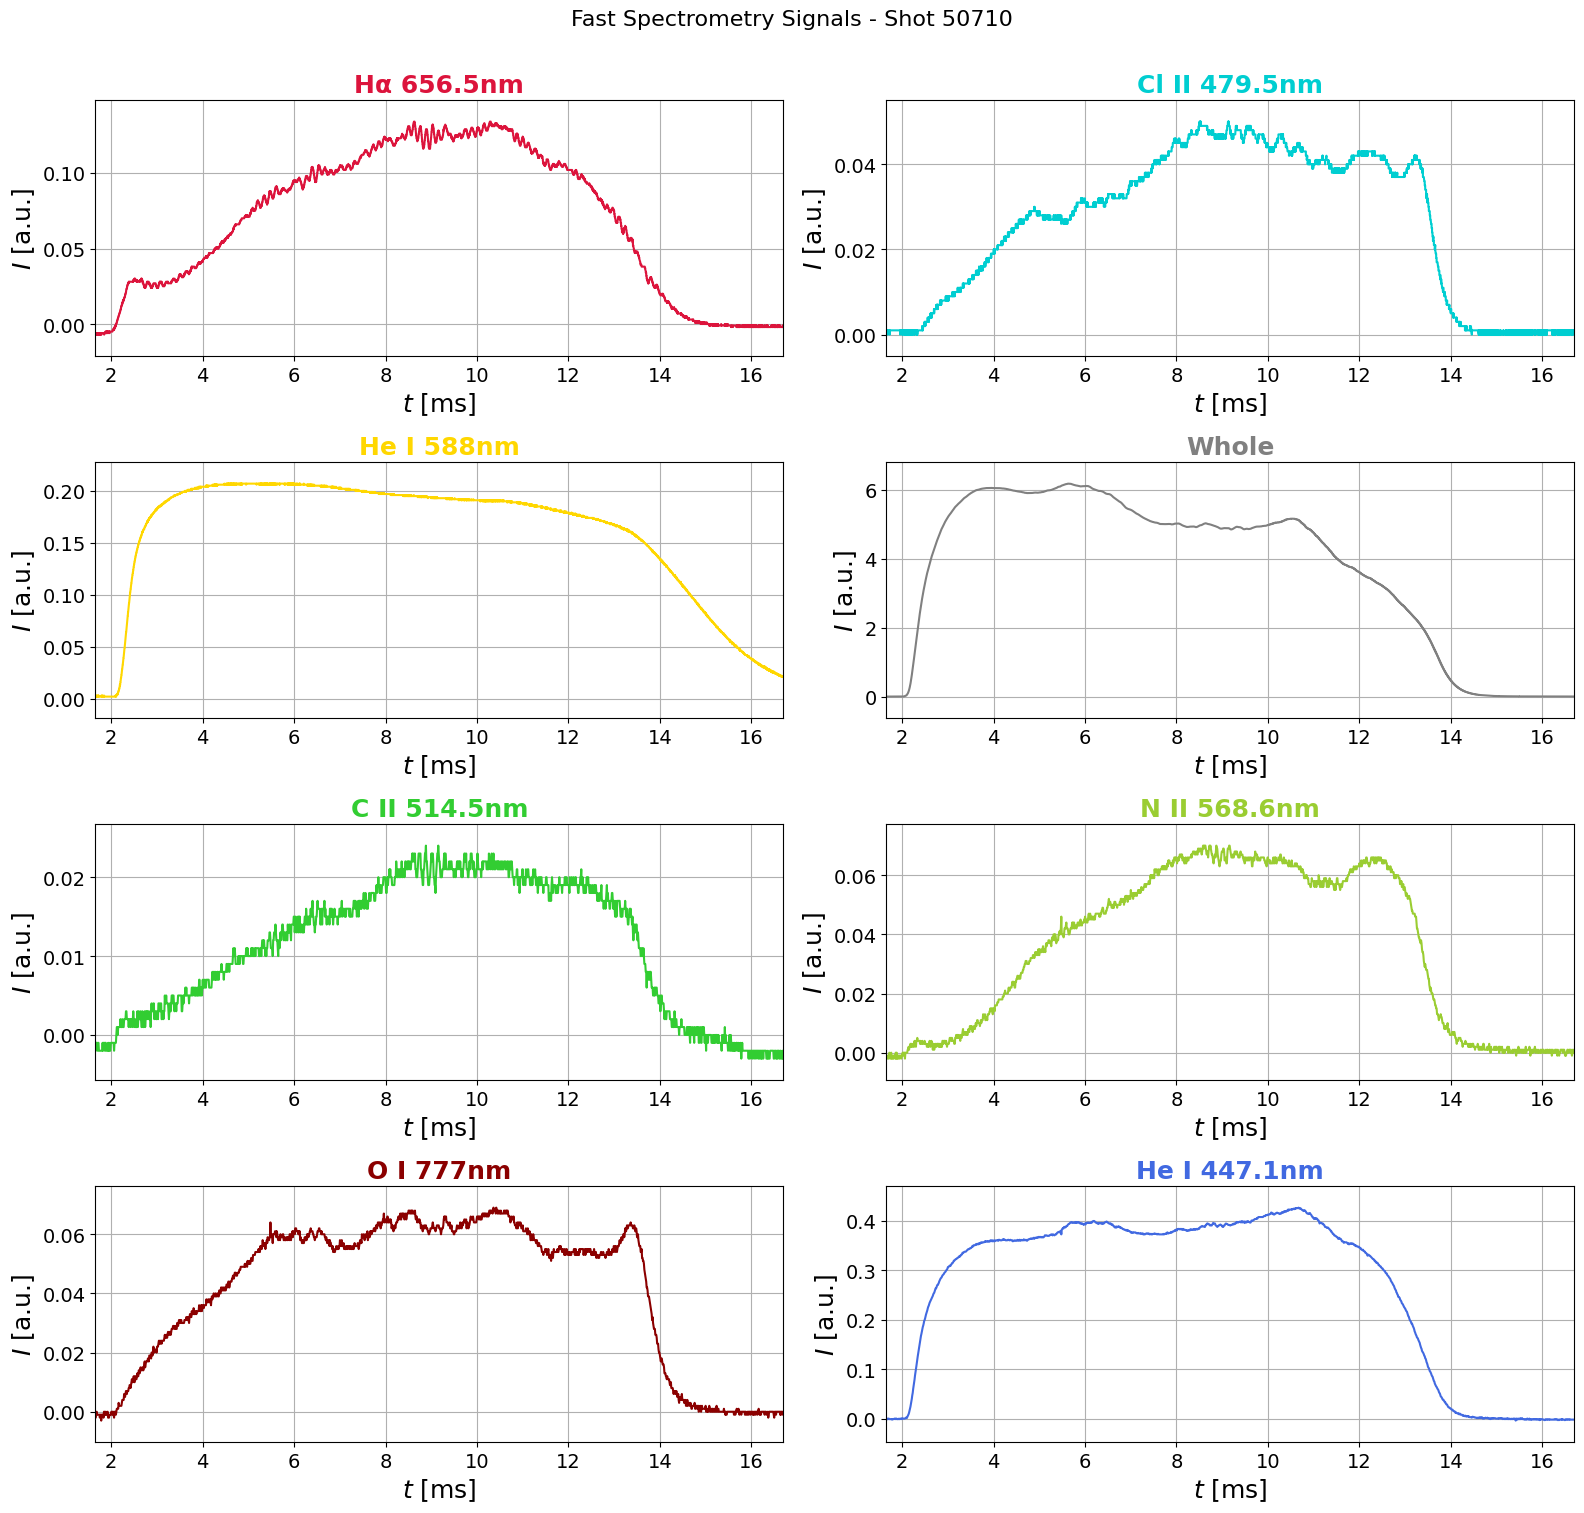

In [94]:
# Define colors for each spectral line based on their wavelengths
line_colors = {
    "Hα 656.5nm": "#DC143C",  # Crimson red (656 nm)
    "Cl II 479.5nm": "#00CED1",  # Dark turquoise (480 nm)
    "He I 588nm": "#FFD700",  # Gold (588 nm)
    "Whole": "#808080",  # Gray (all wavelengths)
    "C II 514.5nm": "#32CD32",  # Lime green (515 nm)
    "N II 568.6nm": "#9ACD32",  # Yellow-green (569 nm)
    "O I 777nm": "#8B0000",  # Dark red (777 nm)
    "He I 447.1nm": "#4169E1",  # Royal blue (447 nm)
}

# One figure, 4x2 grid of subplots
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(16, 16))
axes_flat = axes.flatten()

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter(order, cutoff, fs=fs, btype='low', analog=False)
    y = lfilter(b, a, data)
    return y

for ax, (label, df) in zip(axes_flat, data.items()):
    t = df.iloc[:, 0] * 1e3  # convert to ms
    u = df.iloc[:, 1]
    color = line_colors.get(label, "black")
    ax.plot(t, u, label=label, color=color)
    # ax.plot(t, butter_lowpass_filter(u, 1000, 100e3), label=label)
    # ax.plot(t, u, color="gray", alpha=0.5, label="Noise (Whole)", marker=".")
    ax.set_ylabel(r"$I$ [a.u.]")
    ax.set_xlabel(r"$t$ [ms]")
    ax.grid(True)
    ax.set_title(label, color=color, fontweight='bold')
    # Set xlim based on plasma timing if available
    if loader.plasma_timing:
        ax.set_xlim(loader.plasma_timing.t_plasma_start_ms, loader.plasma_timing.t_plasma_end_ms + 3)
        # Get the mask for the plasma time range to calculate ylim
        mask = (t >= loader.plasma_timing.t_plasma_start_ms) & (t <= loader.plasma_timing.t_plasma_end_ms + 3)
        if mask.any():
            u_range = u[mask]
            y_min, y_max = u_range.min(), u_range.max()
            y_margin = (y_max - y_min) * 0.1  # 10% margin
            ax.set_ylim(y_min - y_margin, y_max + y_margin)
    else:
        ax.set_xlim(0, 25)

# Figure-level title (fontsize controlled by rcParams figure.titlesize)
# Move it slightly closer to the subplots
fig.suptitle(f"Fast Spectrometry Signals - Shot {shotno}", y=0.975)

# Adjust layout; raise the top of the axes area to sit closer to the suptitle
fig.tight_layout(rect=[0, 0.03, 1, 0.97])

# Show the single figure with all four subplots
plt.show()

In [95]:
# Load mini-spectrometer H5 data using the loader module
h5_data = loader.load_minispectrometer_h5()

# Extract spectra and wavelengths
Spectra = h5_data.spectra
Wavelengths = h5_data.wavelengths

print(f"Loaded spectra with shape: {Spectra.shape}")
print(f"Wavelength range: {Wavelengths[0]:.2f} - {Wavelengths[-1]:.2f} nm")

2026-01-10 16:30:21,509 - golem_data_loader.golem_data_loader - INFO - Downloading H5 file to /var/folders/8r/sqs2hl_s6f3fmch121kzp_yh0000gn/T/tmpys3ppcc4.h5
2026-01-10 16:30:21,601 - golem_data_loader.golem_data_loader - INFO - Successfully loaded mini-spectrometer H5 file from http://golem.fjfi.cvut.cz/shots/50710/Diagnostics/MiniSpectrometer/DAS_raw_data_dir/IRVISUV_0.h5
2026-01-10 16:30:21,603 - golem_data_loader.golem_data_loader - INFO - Successfully downloaded H5 file (102864 bytes)
2026-01-10 16:30:21,605 - golem_data_loader.golem_data_loader - INFO - Loaded spectra: shape=(20, 2048), wavelengths: shape=(2047,)
2026-01-10 16:30:21,606 - golem_data_loader.golem_data_loader - INFO - Cleaned up temporary file: /var/folders/8r/sqs2hl_s6f3fmch121kzp_yh0000gn/T/tmpys3ppcc4.h5


Loaded spectra with shape: (20, 2048)
Wavelength range: 188.11 - 1108.53 nm


In [96]:
def normalize(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

def compare_spectrometer(peaks, Wavelengths, Spectra):
    # Create a 4x2 grid of axes and flatten for sequential indexing
    fig, axes = plt.subplots(nrows=4, ncols=2, sharex=True, figsize=(12, 20), sharey=True)
    axes_flat = axes.flatten()

    for n, peak in enumerate(peaks):
        # Select wavelengths within +/- (FWHM/2) around the peak wavelength
        wavelength_mask = (Wavelengths >= peak["wavelength"] - peak["fwhm"]/2) & (Wavelengths <= peak["wavelength"] + peak["fwhm"]/2)
        wavelength_indexes = np.where(wavelength_mask)[0]

        # Create time array and integrate intensity for each spectrum
        mini_spectrometer_t = np.arange(2, 2*len(Spectra)+2, 2)
        mini_spectrometer_intensity = []

        for i in range(len(Spectra)):
            # Extract intensity values at the selected wavelength indexes
            spectrum_slice = Spectra[i][wavelength_indexes]
            # Integrate using trapezoidal rule
            total_intensity = np.trapz(spectrum_slice, Wavelengths[wavelength_indexes])
            mini_spectrometer_intensity.append(total_intensity)

        mini_spectrometer_intensity = np.array(mini_spectrometer_intensity)

        # Plot mini spectrometer integrated intensity over time on the corresponding axis
        ax = axes_flat[n]
        ax.scatter(mini_spectrometer_t, normalize(mini_spectrometer_intensity), label='Mini spectrometer')

        # Add gray plot of Hβ signal passed through butter_lowpass_filter
        start_index = np.nonzero(peak["fs_data"].iloc[:, 0] > 1e-3)[0][0]
        t_hb = peak["fs_data"].iloc[:, 0][start_index:] * 1e3  # convert to ms
        u_hb = peak["fs_data"].iloc[:, 1][start_index:]
        filtered_hb = butter_lowpass_filter(u_hb, 2000, 100e3)
        ax.plot(t_hb, normalize(filtered_hb), color='gray', label='Fast spectrometer')

        ax.set_xlabel('Time (ms)')
        ax.set_ylabel('Integrated Intensity (a.u.)')
        ax.set_title(f"{peak['name']}")
        
        # Set xlim based on plasma timing if available
        if loader.plasma_timing:
            ax.set_xlim(loader.plasma_timing.t_plasma_start_ms - 2, loader.plasma_timing.t_plasma_end_ms + 2)

        ax.grid(True)
        ax.legend()

    fig.suptitle(f"Mini Spectrometer and Fast Spectrometer Signals - Shot {shotno}", fontsize=16, y=0.995)
    fig.tight_layout()
    plt.show()


/var/folders/8r/sqs2hl_s6f3fmch121kzp_yh0000gn/T/ipykernel_13981/2710262732.py:22: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  total_intensity = np.trapz(spectrum_slice, Wavelengths[wavelength_indexes])


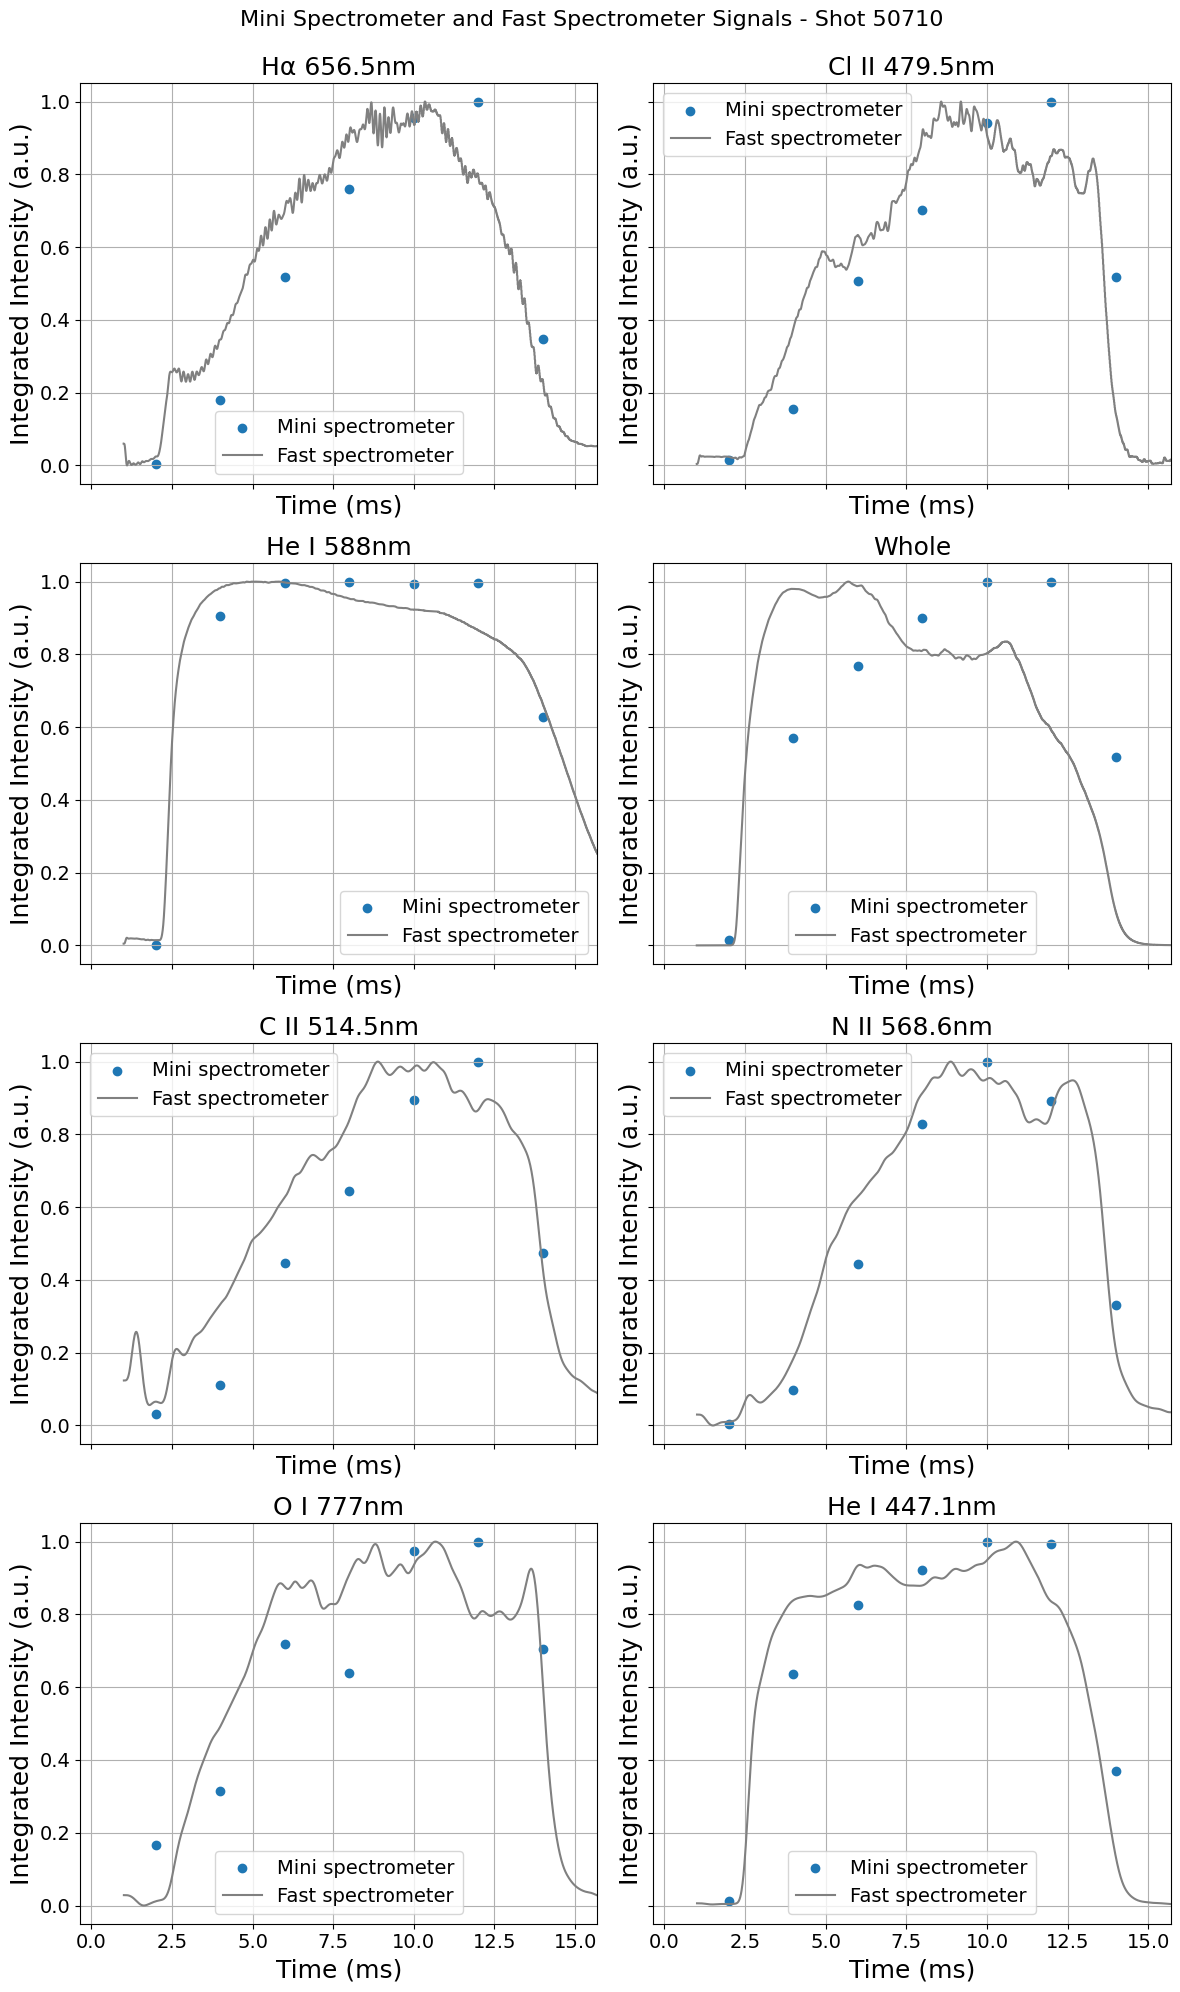

In [97]:
peaks = [
  {
    "name": "Hα 656.5nm",
    "wavelength": 656.0,
    "fwhm": 10,
    "fs_data": data["Hα 656.5nm"]
  },
  {
    "name": "Cl II 479.5nm",
    "wavelength": 480.0,
    "fwhm": 10,
    "fs_data": data["Cl II 479.5nm"]
  },
  {
    "name": "He I 588nm",
    "wavelength": 590.0,
    "fwhm": 10,
    "fs_data": data["He I 588nm"]
  },
  {
    "name": "Whole",
    "wavelength": 500.0,
    "fwhm": 300,
    "fs_data": data["Whole"]
  },
  {
    "name": "C II 514.5nm",
    "wavelength": 515.0,
    "fwhm": 10,
    "fs_data": data["C II 514.5nm"]
  },
  {
    "name": "N II 568.6nm",
    "wavelength": 570.0,
    "fwhm": 10,
    "fs_data": data["N II 568.6nm"]
  },
  {
    "name": "O I 777nm",
    "wavelength": 780.0,
    "fwhm": 10,
    "fs_data": data["O I 777nm"]
  },
  {
    "name": "He I 447.1nm",
    "wavelength": 450.0,
    "fwhm": 10,
    "fs_data": data["He I 447.1nm"]
  }
]

compare_spectrometer(peaks, Wavelengths, Spectra)

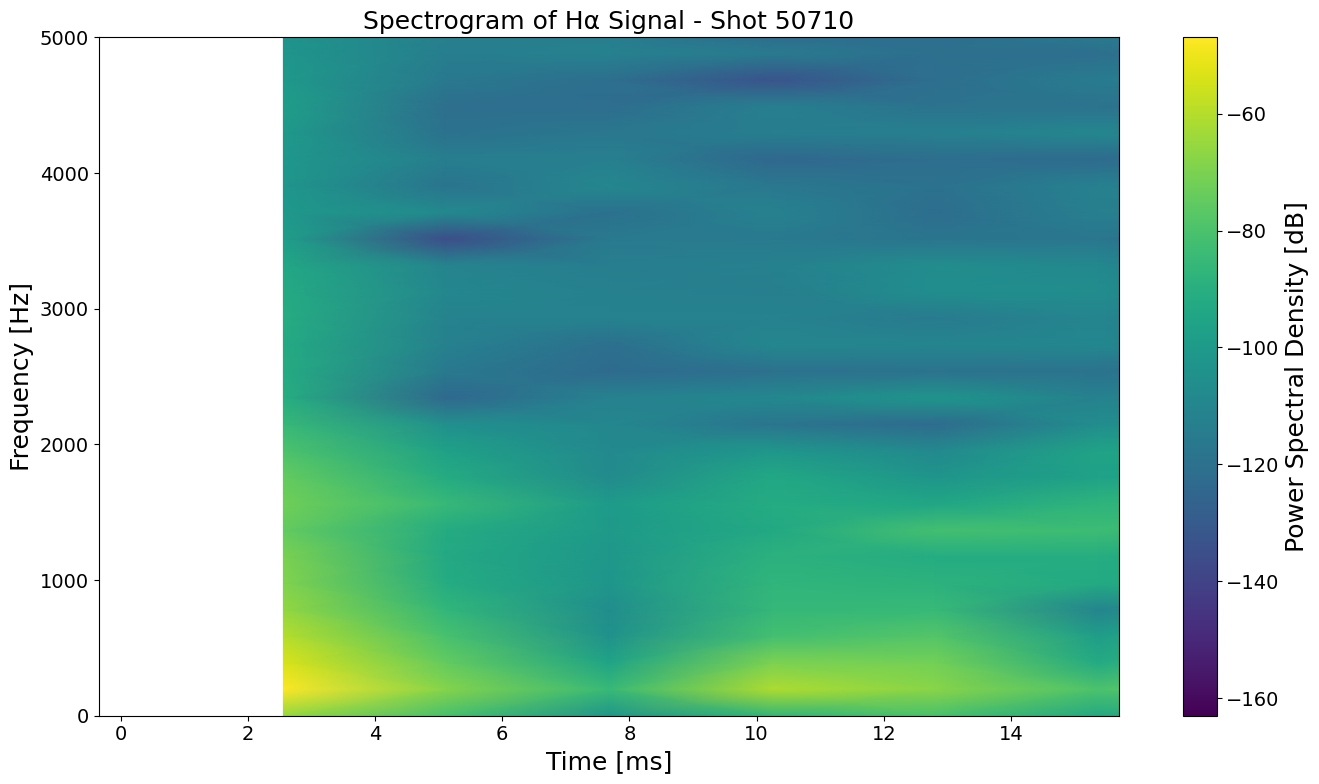

In [98]:
from scipy import signal

# Extract Hα signal data
ha_df = data["Hα 656.5nm"]
t_ha = ha_df.iloc[:, 0].values  # time in seconds
u_ha = ha_df.iloc[:, 1].values  # intensity

# Spectrogram parameters
fs = 100e3  # Sampling frequency (100 kHz)
nperseg = 512  # Length of each segment for STFT
noverlap = nperseg // 2  # Overlap between segments

# Compute the spectrogram using Short-Time Fourier Transform
frequencies, times, Sxx = signal.spectrogram(u_ha, fs=fs, nperseg=nperseg, noverlap=noverlap)

# Create the spectrogram plot
fig, ax = plt.subplots(figsize=(14, 8))

# Plot spectrogram with logarithmic scale for better visibility
pcm = ax.pcolormesh(times * 1e3, frequencies, 10 * np.log10(Sxx), 
                     shading='gouraud', cmap='viridis')

ax.set_ylabel('Frequency [Hz]')
ax.set_xlabel('Time [ms]')
ax.set_title(f'Spectrogram of Hα Signal - Shot {shotno}')
ax.set_ylim(0, 5000)  # Focus on 0-5 kHz range

# Set xlim based on plasma timing if available
if loader.plasma_timing:
    ax.set_xlim(loader.plasma_timing.t_plasma_start_ms - 2, loader.plasma_timing.t_plasma_end_ms + 2)
else:
    ax.set_xlim(0, 15)

# Add colorbar
cbar = fig.colorbar(pcm, ax=ax, label='Power Spectral Density [dB]')

plt.tight_layout()
plt.show()


## Demonstration: Mini-Spectrometer Data to Time-Dependent Signal Conversion

This visualization shows how the `compare_spectrometer` function converts full spectral data into time-dependent signals by:
1. Selecting a wavelength region around a spectral line (peak ± FWHM/2)
2. Integrating the intensity over that wavelength range
3. Repeating for each time point to create a time series

Wavelengths shape: (2047,), Spectra shape: (20, 2048)
Selected spectrum index 5 (t = 10 ms) with max Hα intensity


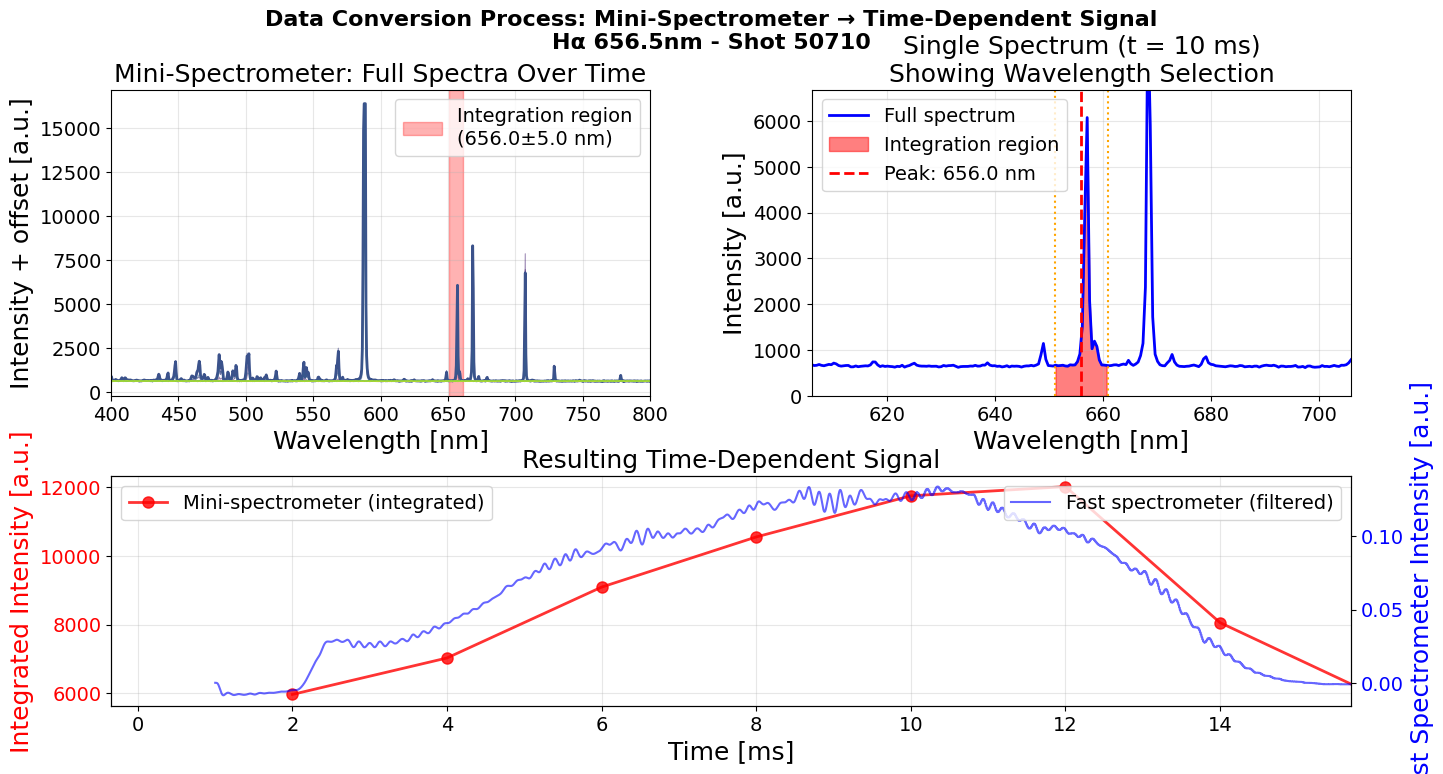

In [105]:
# Demonstration of data conversion for Hα line
peak_demo = {
    "name": "Hα 656.5nm",
    "wavelength": 656.0,
    "fwhm": 10,
    "fs_data": data["Hα 656.5nm"]
}

# Check dimensions and fix if needed
print(f"Wavelengths shape: {Wavelengths.shape}, Spectra shape: {Spectra.shape}")

# Find the spectrum with the strongest Hα signal
min_len_check = min(len(Wavelengths), len(Spectra[0]))
wavelength_mask_check = (Wavelengths[:min_len_check] >= peak_demo["wavelength"] - peak_demo["fwhm"]/2) & \
                        (Wavelengths[:min_len_check] <= peak_demo["wavelength"] + peak_demo["fwhm"]/2)
wavelength_indexes_check = np.where(wavelength_mask_check)[0]

# Calculate integrated intensity for each spectrum to find the peak
intensities = []
for i in range(len(Spectra)):
    spectrum_slice = Spectra[i][wavelength_indexes_check]
    total = np.trapezoid(spectrum_slice, Wavelengths[wavelength_indexes_check])
    intensities.append(total)

# Choose spectrum with maximum Hα intensity (should be around plasma peak)
demo_spectrum_idx = np.argmax(intensities)
print(f"Selected spectrum index {demo_spectrum_idx} (t = {demo_spectrum_idx*2} ms) with max Hα intensity")

# Create a comprehensive visualization
fig = plt.figure(figsize=(16, 8))

# Define grid for subplot layout
gs = fig.add_gridspec(2, 2, height_ratios=[2, 1.5], hspace=0.3, wspace=0.3)

# --- Top left: 3D-like view of spectra over time ---
ax1 = fig.add_subplot(gs[0, 0])

# Show every spectrum to see the evolution
step = 1
for i in range(0, len(Spectra), step):
    # Ensure we only use the overlapping part
    min_len = min(len(Wavelengths), len(Spectra[i]))
    # Offset each spectrum vertically for 3D effect
    offset = i * 0.5
    alpha_val = 1.0 if i == demo_spectrum_idx else 0.5
    lw = 2 if i == demo_spectrum_idx else 0.8
    ax1.plot(Wavelengths[:min_len], Spectra[i][:min_len] + offset, 
             alpha=alpha_val, linewidth=lw, color=plt.cm.viridis(i/len(Spectra)))

# Highlight the wavelength region of interest
wavelength_mask = (Wavelengths >= peak_demo["wavelength"] - peak_demo["fwhm"]/2) & \
                  (Wavelengths <= peak_demo["wavelength"] + peak_demo["fwhm"]/2)
ax1.axvspan(peak_demo["wavelength"] - peak_demo["fwhm"]/2, 
            peak_demo["wavelength"] + peak_demo["fwhm"]/2, 
            alpha=0.3, color='red', label=f'Integration region\n({peak_demo["wavelength"]}±{peak_demo["fwhm"]/2} nm)')

ax1.set_xlabel('Wavelength [nm]')
ax1.set_ylabel('Intensity + offset [a.u.]')
ax1.set_title('Mini-Spectrometer: Full Spectra Over Time')
ax1.set_xlim(400, 800)
ax1.legend(loc='upper right')
ax1.grid(True, alpha=0.3)

# --- Top right: Single spectrum showing wavelength selection ---
ax2 = fig.add_subplot(gs[0, 1])

# Use the spectrum with maximum Hα intensity
min_len = min(len(Wavelengths), len(Spectra[demo_spectrum_idx]))
ax2.plot(Wavelengths[:min_len], Spectra[demo_spectrum_idx][:min_len], 'b-', linewidth=2, label='Full spectrum')

# Highlight the selected wavelength region - recalculate mask for the correct length
wavelength_mask_ax2 = (Wavelengths[:min_len] >= peak_demo["wavelength"] - peak_demo["fwhm"]/2) & \
                       (Wavelengths[:min_len] <= peak_demo["wavelength"] + peak_demo["fwhm"]/2)
wavelength_indexes = np.where(wavelength_mask_ax2)[0]

ax2.fill_between(Wavelengths[wavelength_indexes], 
                 0, 
                 Spectra[demo_spectrum_idx][wavelength_indexes], 
                 alpha=0.5, color='red', label='Integration region')

ax2.axvline(peak_demo["wavelength"], color='red', linestyle='--', linewidth=2, label=f'Peak: {peak_demo["wavelength"]} nm')
ax2.axvline(peak_demo["wavelength"] - peak_demo["fwhm"]/2, color='orange', linestyle=':', linewidth=1.5)
ax2.axvline(peak_demo["wavelength"] + peak_demo["fwhm"]/2, color='orange', linestyle=':', linewidth=1.5)

ax2.set_xlabel('Wavelength [nm]')
ax2.set_ylabel('Intensity [a.u.]')
ax2.set_title(f'Single Spectrum (t = {demo_spectrum_idx*2} ms)\nShowing Wavelength Selection')
ax2.set_xlim(peak_demo["wavelength"] - 50, peak_demo["wavelength"] + 50)
# Set ylim to focus on the region with the peak
y_min = Spectra[demo_spectrum_idx][wavelength_indexes].min() * 0.9
y_max = Spectra[demo_spectrum_idx][wavelength_indexes].max() * 1.1
ax2.set_ylim(0, y_max)
ax2.legend()
ax2.grid(True, alpha=0.3)

# --- Bottom: Resulting time-dependent signal ---
ax4 = fig.add_subplot(gs[1, :])

# Perform the same conversion as in compare_spectrometer function
mini_spectrometer_t = np.arange(2, 2*len(Spectra)+2, 2)
mini_spectrometer_intensity = []

for i in range(len(Spectra)):
    min_len_i = min(len(Wavelengths), len(Spectra[i]))
    wavelength_mask_i = (Wavelengths[:min_len_i] >= peak_demo["wavelength"] - peak_demo["fwhm"]/2) & \
                        (Wavelengths[:min_len_i] <= peak_demo["wavelength"] + peak_demo["fwhm"]/2)
    wavelength_indexes_i = np.where(wavelength_mask_i)[0]
    
    spectrum_slice = Spectra[i][wavelength_indexes_i]
    total_intensity = np.trapezoid(spectrum_slice, Wavelengths[wavelength_indexes_i])
    mini_spectrometer_intensity.append(total_intensity)

mini_spectrometer_intensity = np.array(mini_spectrometer_intensity)

# Plot both mini spectrometer and fast spectrometer
ax4.plot(mini_spectrometer_t, mini_spectrometer_intensity, 'ro-', 
         markersize=8, linewidth=2, label='Mini-spectrometer (integrated)', alpha=0.8)

# Add fast spectrometer comparison
start_index = np.nonzero(peak_demo["fs_data"].iloc[:, 0] > 1e-3)[0][0]
t_fs = peak_demo["fs_data"].iloc[:, 0][start_index:] * 1e3  # convert to ms
u_fs = peak_demo["fs_data"].iloc[:, 1][start_index:]
filtered_fs = butter_lowpass_filter(u_fs, 2000, 100e3)

# Normalize both for comparison
ax4_twin = ax4.twinx()
ax4_twin.plot(t_fs, filtered_fs, 'b-', alpha=0.6, linewidth=1.5, label='Fast spectrometer (filtered)')
ax4_twin.set_ylabel('Fast Spectrometer Intensity [a.u.]', color='b')
ax4_twin.tick_params(axis='y', labelcolor='b')

ax4.set_xlabel('Time [ms]')
ax4.set_ylabel('Integrated Intensity [a.u.]', color='r')
ax4.set_title('Resulting Time-Dependent Signal')
ax4.tick_params(axis='y', labelcolor='r')

# Set xlim based on plasma timing if available
if loader.plasma_timing:
    ax4.set_xlim(loader.plasma_timing.t_plasma_start_ms - 2, loader.plasma_timing.t_plasma_end_ms + 2)

ax4.grid(True, alpha=0.3)
ax4.legend(loc='upper left')
ax4_twin.legend(loc='upper right')

fig.suptitle(f'Data Conversion Process: Mini-Spectrometer → Time-Dependent Signal\n{peak_demo["name"]} - Shot {shotno}', 
             fontsize=16, fontweight='bold')

plt.show()